In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, balanced_accuracy_score, classification_report
)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [19]:
df = pd.read_csv("data/merged_features.csv")
df["Date"] = pd.to_datetime(df["Date"])

features = ["Return","RollingVol","RSI","SMA_20","SMA_50","Volume_Z","VIX"]
target = "Direction"

In [20]:
# Leak Fix
# Predict Future Movement
df = df.sort_values(["Ticker", "Date"])
df["Target"] = df.groupby("Ticker")["Direction"].shift(-1)
df.dropna(subset=features + ["Target"], inplace=True)

In [21]:
# Split Train Test 
# Avoid Cross Stock Leakage
tickers = df["Ticker"].unique()
train_list, test_list = [], []

for t in tickers:
    temp = df[df["Ticker"] == t]
    cut = int(len(temp) * 0.8)
    train_list.append(temp.iloc[:cut])
    test_list.append(temp.iloc[cut:])

train = pd.concat(train_list)
test = pd.concat(test_list)

X_train = train[features]
X_test = test[features]
y_train = train["Target"]
y_test = test["Target"]

In [22]:
# Standardize Features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Based on Train Data
X_test_scaled = scaler.transform(X_test)

In [23]:
# Helper Evaluation (expanded metrics)
def evaluate_model(name, y_true, preds, probs=None):
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, preds),
        "F1": f1_score(y_true, preds),
        "Precision": precision_score(y_true, preds, zero_division=0),
        "Recall": recall_score(y_true, preds, zero_division=0),
        "BalancedAcc": balanced_accuracy_score(y_true, preds)
    }
    if probs is not None:
        metrics["ROC AUC"] = roc_auc_score(y_true, probs)

    print(f"\n{name} Results")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"Balanced Acc: {metrics['BalancedAcc']:.4f}")
    if probs is not None:
        print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    return metrics


In [24]:
# Added: simple time-series CV per ticker (3 folds) using XGBoost

def time_series_cv(df, features, target_col_next, model_fn, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rows = []
    tickers = df["Ticker"].unique()

    # Pre-split indexes per ticker so folds align
    splits_by_ticker = {}
    for t in tickers:
        temp = df[df["Ticker"] == t]
        splits_by_ticker[t] = list(tscv.split(temp))

    for fold in range(n_splits):
        train_parts, test_parts = [], []
        for t in tickers:
            temp = df[df["Ticker"] == t]
            tr_idx, te_idx = splits_by_ticker[t][fold]
            train_parts.append(temp.iloc[tr_idx])
            test_parts.append(temp.iloc[te_idx])
        train_fold = pd.concat(train_parts)
        test_fold = pd.concat(test_parts)

        X_tr, y_tr = train_fold[features], train_fold[target_col_next]
        X_te, y_te = test_fold[features], test_fold[target_col_next]

        model = model_fn()
        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)
        probs = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else None
        metrics = evaluate_model(f"Fold {fold+1}", y_te, preds, probs)
        rows.append(metrics)

    return pd.DataFrame(rows)

cv_xgb_small = lambda: XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

# Run CV on direction target
ts_cv_results = time_series_cv(df, features, "Target", cv_xgb_small, n_splits=3)
print("\nTime-series CV summary (mean, numeric cols only):")
print(ts_cv_results.drop(columns=["Model"]).mean(numeric_only=True))



Fold 1 Results
Accuracy: 0.5070
F1 Score: 0.5535
Precision: 0.5412
Recall: 0.5663
Balanced Acc: 0.5019
ROC AUC: 0.5064

Fold 2 Results
Accuracy: 0.5173
F1 Score: 0.6268
Precision: 0.5182
Recall: 0.7931
Balanced Acc: 0.5110
ROC AUC: 0.5189

Fold 3 Results
Accuracy: 0.5233
F1 Score: 0.5893
Precision: 0.5421
Recall: 0.6454
Balanced Acc: 0.5156
ROC AUC: 0.5179

Time-series CV summary (mean, numeric cols only):
Accuracy       0.515847
F1             0.589843
Precision      0.533810
Recall         0.668280
BalancedAcc    0.509475
ROC AUC        0.514384
dtype: float64


In [25]:
# Added: simple baselines for context
rng = np.random.default_rng(42)
pred_coin = rng.integers(0, 2, size=len(y_test))

# Repeat last known direction as next-day prediction
baseline_last = test["Direction"].values
# Majority class from train set
majority_class = y_train.mode()[0]
pred_majority = np.full(len(y_test), majority_class)

_ = evaluate_model("Baseline: coin flip", y_test, pred_coin)
_ = evaluate_model("Baseline: repeat last direction", y_test, baseline_last)
_ = evaluate_model("Baseline: majority class", y_test, pred_majority)



Baseline: coin flip Results
Accuracy: 0.4997
F1 Score: 0.5124
Precision: 0.5341
Recall: 0.4924
Balanced Acc: 0.5002

Baseline: repeat last direction Results
Accuracy: 0.5146
F1 Score: 0.5456
Precision: 0.5453
Recall: 0.5458
Balanced Acc: 0.5123

Baseline: majority class Results
Accuracy: 0.5338
F1 Score: 0.6961
Precision: 0.5338
Recall: 1.0000
Balanced Acc: 0.5000


In [26]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

pred_lr = logreg.predict(X_test_scaled)
proba_lr = logreg.predict_proba(X_test_scaled)[:,1]

_ = evaluate_model("Logistic Regression", y_test, pred_lr, proba_lr)


Logistic Regression Results
Accuracy: 0.5325
F1 Score: 0.6883
Precision: 0.5344
Recall: 0.9667
Balanced Acc: 0.5010
ROC AUC: 0.4971


In [27]:
# Added: calibrated logistic regression for better probabilities
calibrated_lr = CalibratedClassifierCV(
    estimator=LogisticRegression(max_iter=1000),
    method="isotonic",
    cv=5
)
calibrated_lr.fit(X_train_scaled, y_train)

pred_lr_cal = calibrated_lr.predict(X_test_scaled)
proba_lr_cal = calibrated_lr.predict_proba(X_test_scaled)[:,1]

_ = evaluate_model("Logistic Regression (calibrated)", y_test, pred_lr_cal, proba_lr_cal)



Logistic Regression (calibrated) Results
Accuracy: 0.5309
F1 Score: 0.6798
Precision: 0.5348
Recall: 0.9328
Balanced Acc: 0.5018
ROC AUC: 0.4992


In [28]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]

_ = evaluate_model("Random Forest", y_test, pred_rf, proba_rf)


Random Forest Results
Accuracy: 0.5244
F1 Score: 0.6588
Precision: 0.5339
Recall: 0.8600
Balanced Acc: 0.5001
ROC AUC: 0.4933


In [29]:
# Added: HistGradientBoosting tree model
hgb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=400,
    random_state=42
)

hgb.fit(X_train, y_train)
pred_hgb = hgb.predict(X_test)
proba_hgb = hgb.predict_proba(X_test)[:,1]

_ = evaluate_model("HistGradientBoosting", y_test, pred_hgb, proba_hgb)



HistGradientBoosting Results
Accuracy: 0.5266
F1 Score: 0.6488
Precision: 0.5371
Recall: 0.8191
Balanced Acc: 0.5054
ROC AUC: 0.5070


In [30]:
# Youtube New Concept Learned
# XGBoost
xgb = XGBClassifier( # Enure Package Downloaded Through Term
    n_estimators=500,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
proba_xgb = xgb.predict_proba(X_test)[:,1]

_ = evaluate_model("XGBoost", y_test, pred_xgb, proba_xgb)


XGBoost Results
Accuracy: 0.5120
F1 Score: 0.5600
Precision: 0.5398
Recall: 0.5818
Balanced Acc: 0.5069
ROC AUC: 0.5090


In [31]:
# Added: quick hyperparameter search (small) for XGBoost and HistGradientBoosting
xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ),
    param_distributions={
        "max_depth": [3,5,7],
        "learning_rate": [0.02, 0.05, 0.1],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.7, 0.85, 1.0],
        "n_estimators": [200, 400, 600]
    },
    n_iter=8,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=1
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

pred_xgb_best = best_xgb.predict(X_test)
proba_xgb_best = best_xgb.predict_proba(X_test)[:,1]

_ = evaluate_model("XGBoost (tuned)", y_test, pred_xgb_best, proba_xgb_best)

hgb_search = RandomizedSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_distributions={
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "max_iter": [200, 400, 600],
        "min_samples_leaf": [10, 20, 50]
    },
    n_iter=8,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=1
)

hgb_search.fit(X_train, y_train)
best_hgb = hgb_search.best_estimator_

pred_hgb_best = best_hgb.predict(X_test)
proba_hgb_best = best_hgb.predict_proba(X_test)[:,1]

_ = evaluate_model("HistGradientBoosting (tuned)", y_test, pred_hgb_best, proba_hgb_best)



XGBoost (tuned) Results
Accuracy: 0.5114
F1 Score: 0.5667
Precision: 0.5381
Recall: 0.5986
Balanced Acc: 0.5051
ROC AUC: 0.5093

HistGradientBoosting (tuned) Results
Accuracy: 0.5294
F1 Score: 0.6512
Precision: 0.5387
Recall: 0.8229
Balanced Acc: 0.5080
ROC AUC: 0.5071


In [32]:
# Model comparison (ordered; tuned variants excluded)
results = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Logistic Regression (calibrated)",
        "Random Forest",
        "HistGradientBoosting",
        "XGBoost"
    ],
    "Accuracy": [
        accuracy_score(y_test, pred_lr),
        accuracy_score(y_test, pred_lr_cal),
        accuracy_score(y_test, pred_rf),
        accuracy_score(y_test, pred_hgb),
        accuracy_score(y_test, pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test, pred_lr),
        f1_score(y_test, pred_lr_cal),
        f1_score(y_test, pred_rf),
        f1_score(y_test, pred_hgb),
        f1_score(y_test, pred_xgb)
    ],
    "Precision": [
        precision_score(y_test, pred_lr),
        precision_score(y_test, pred_lr_cal),
        precision_score(y_test, pred_rf),
        precision_score(y_test, pred_hgb),
        precision_score(y_test, pred_xgb)
    ],
    "Recall": [
        recall_score(y_test, pred_lr),
        recall_score(y_test, pred_lr_cal),
        recall_score(y_test, pred_rf),
        recall_score(y_test, pred_hgb),
        recall_score(y_test, pred_xgb)
    ],
    "Balanced Acc": [
        balanced_accuracy_score(y_test, pred_lr),
        balanced_accuracy_score(y_test, pred_lr_cal),
        balanced_accuracy_score(y_test, pred_rf),
        balanced_accuracy_score(y_test, pred_hgb),
        balanced_accuracy_score(y_test, pred_xgb)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, proba_lr),
        roc_auc_score(y_test, proba_lr_cal),
        roc_auc_score(y_test, proba_rf),
        roc_auc_score(y_test, proba_hgb),
        roc_auc_score(y_test, proba_xgb)
    ]
})

# Sorted by Accuracy then F1 for readability; rank is 1=best
sorted_results = results.sort_values(["Accuracy","F1 Score"], ascending=False).reset_index(drop=True)
sorted_results.index = sorted_results.index + 1  # rank
display(sorted_results)


,Model,Accuracy,F1 Score,Precision,Recall,Balanced Acc,ROC AUC
1,Logistic Regression,0.532533,0.688265,0.534361,0.966685,0.501022,0.497110
2,Logistic Regression (calibrated),0.530943,0.679826,0.534783,0.932828,0.501774,0.499171
3,HistGradientBoosting,0.526605,0.648788,0.537123,0.819068,0.505378,0.507010
4,Random Forest,0.524436,0.658782,0.533883,0.859967,0.500083,0.493307
5,XGBoost,0.512001,0.560031,0.539834,0.581798,0.506935,0.509045


### Added: why tuned models are excluded
The tuned variants are left in the notebook for reference, but their performance was worse on this dataset (lower Accuracy/F1/ROC AUC). The comparison table above only shows the baseline models and the calibrated logistic. Models are ranked (index = 1 is best) by Accuracy then F1. 

In [33]:
# Added: classification report for best-performing model (XGBoost)
print(classification_report(y_test, pred_xgb, target_names=["Down","Up"]))


              precision    recall  f1-score   support

        Down       0.47      0.43      0.45      3224
          Up       0.54      0.58      0.56      3692

    accuracy                           0.51      6916
   macro avg       0.51      0.51      0.51      6916
weighted avg       0.51      0.51      0.51      6916



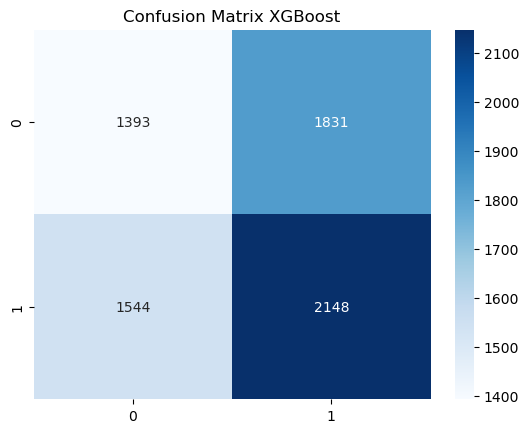

In [34]:
# Confusion Matrix XGBoost
sns.heatmap(confusion_matrix(y_test, pred_xgb), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix XGBoost")
plt.show()